In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import wget
import os

import datetime





In [2]:
# Setting parameters
config = {
    'days_to_forecast': 3,
    'global_degree': 5,
    'new_case_degree': 3,
    'terapia_intensiva': 2,
    'time': int(str(datetime.datetime.now().time())[0:2]),
    'update_data': 18,
    'start_date': datetime.date(2020, 3, 16)
}

path_img = 'img/'
path_data = 'save_data/'



In [3]:

# Define linear regression  methods
def train_model(x, y, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    return model




In [4]:
# Model predictions
def get_predictions(x, model, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(x)

    return model.predict(x_poly)





In [5]:
# Call model forecasting
def call_model(model_name, model, x, y, days_to_predict, degree):
    y_pred = np.round(get_predictions(x, model, degree), 0).astype(np.int32)

    predictions = forecast(model_name, model, degree, beginning_day=len(x), limit=days_to_predict)
    print("")
    return predictions




In [6]:
# Forecast next days
def forecast(model_name, model, degree, beginning_day=0, limit=10):
    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = np.round(get_predictions(next_days_x, model, degree), 0).astype(np.int32)

    print("The results for " + model_name + " in the following " + str(limit) + " days is:")

    for i in range(0, limit):
        print(str(i + 1) + ": " + str(next_days_pred[i]))
    collect_predictions(next_days_pred, model_name)
    return next_days_pred




In [7]:
# Plot results
def plot_prediction(y, predictions, title):
    total_days = [datetime.date(2020, 2, 24) + datetime.timedelta(days=int(i)) for i in range(int(y.shape[0]) + predictions.shape[0])]

    if config['time'] >= config['update_data']:
        today = str(datetime.date.today())
        last_day = str(datetime.date.today() + datetime.timedelta(days=config['days_to_forecast']))
    else:
        today = str(datetime.date.today() - datetime.timedelta(1))
        last_day = str(datetime.date.today() - datetime.timedelta(1) + datetime.timedelta(days=config['days_to_forecast']))

    final_dates = []
    for i in total_days:
        i = str(i)
        final_dates.append(i[5:])

    y = np.array(y)
    y = y.reshape((y.shape[0]), 1)
    predictions = np.array(predictions)
    predictions = predictions.reshape((predictions.shape[0]), 1)

    series = np.concatenate([y, predictions], axis=0)

    #old = load_predictions(title)

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(final_dates, series, label='Predicted cases')
    ax.plot(y, color='red', label='Verified cases')
    fig.autofmt_xdate()
    plt.gca().xaxis.set_major_locator(plt.LinearLocator(numticks=30))
    ax.axvspan(today[5:], last_day[5:], alpha=0.25)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    fig.savefig(path_img + title.replace(" ", "") + ".png")




In [8]:
# Save old predictions
def collect_predictions(data, title):
    if config['time'] >= config['update_data']:
        filename = str(datetime.date.today() + datetime.timedelta(1))

    else:
        filename = str(datetime.date.today())

    filename = filename.replace('-', '_')
    np.save(path_data + title.replace(" ", "") + filename + '.npy', data)




In [9]:
def load_predictions(title):
    start = config['start_date']
    predictions = [np.nan] * 21
    if config['time'] >= config['update_data']:
        while start != datetime.date.today() + datetime.timedelta(1):
            filename = str(start)
            to_append = np.load(path_data + title.replace(" ", "") + filename.replace('-', '_') + '.npy')
            predictions.append(to_append)
            start = start + + datetime.timedelta(1)
    else:
        while start != datetime.date.today():
            filename = str(start)
            to_append = np.load(path_data + title.replace(" ", "") + filename.replace('-', '_') + '.npy')
            predictions.append(to_append[0])
            start = start + + datetime.timedelta(1)
    predictions = np.array(predictions)
    print(predictions.shape)
    return predictions



The results for Italian total cases prediction in the following 3 days is:
1: 5643183
2: 5674560
3: 5706579



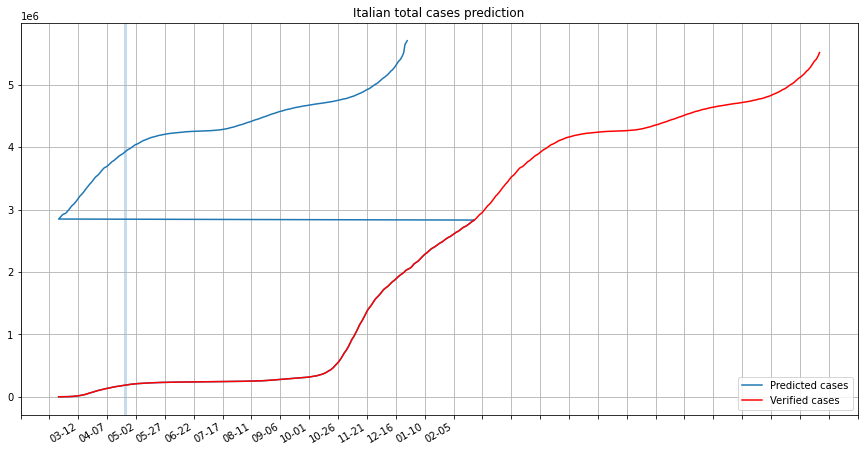

The results for Italian new-daily cases prediction in the following 3 days is:
1: 8663
2: 8788
3: 8913



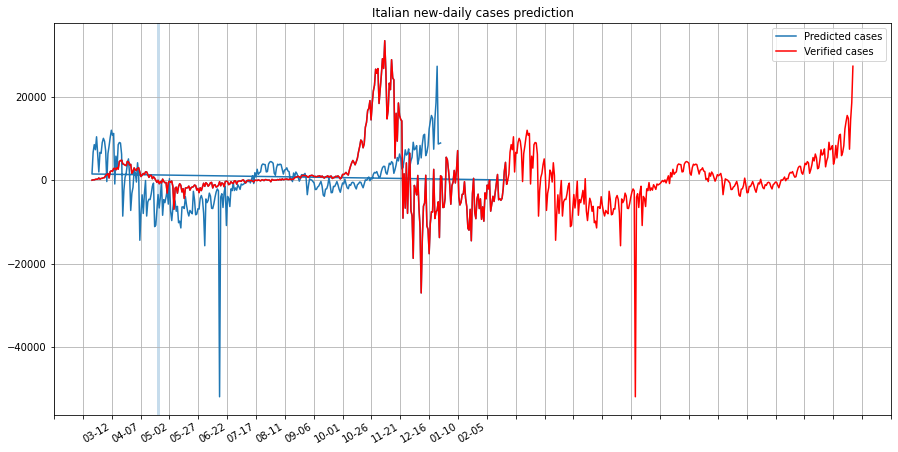

The results for Italian daily intensive Care patients in the following 3 days is:
1: 6
2: 7
3: 7



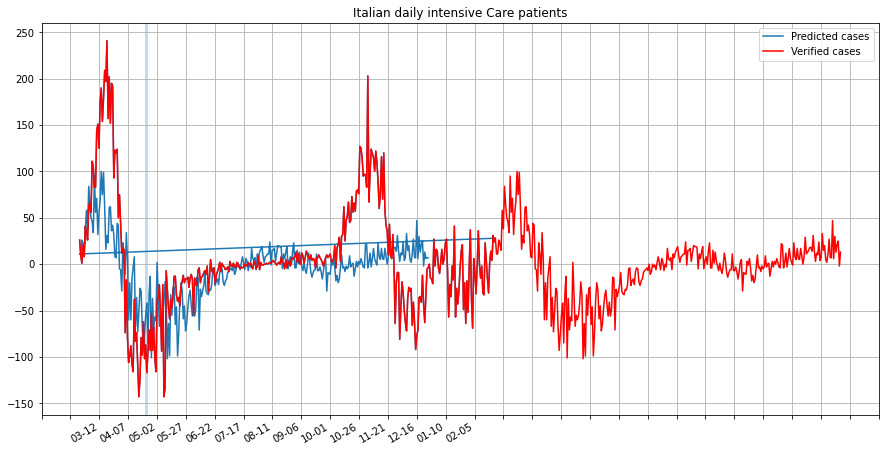

In [10]:

# Arrange data and run the routine
def routine(series, title, degree):
    first_c = np.array(range(0, series.shape[0]))
    first_c = first_c.reshape((first_c.shape[0]), 1)
    series = series.reshape((series.shape[0], 1))
    series = np.concatenate([first_c, series], axis=1)

    x = series[:, 0].reshape(-1, 1)
    y = series[:, 1]

    model = train_model(x, y, degree)
    predictions = call_model(title, model, x, y, config["days_to_forecast"], degree)
    plot_prediction(y, predictions, title)

# Get series
series = pd.read_csv('data.csv')
series_nuovi_positivi = np.array(series['variazione_totale_positivi'])
series_totale_casi = np.array(series['totale_casi'])

series_terapia_intensiva = series['terapia_intensiva']
first = series_terapia_intensiva.head(1)
series_terapia_intensiva = np.array(series_terapia_intensiva.diff().fillna(first))
partition = series_totale_casi.shape[0]

# Train and forecast
routine(series_totale_casi[0:partition], 'Italian total cases prediction', config['global_degree'])
routine(series_nuovi_positivi[0:partition], 'Italian new-daily cases prediction', config['new_case_degree'])
routine(series_terapia_intensiva[0:partition], 'Italian daily intensive Care patients', config['terapia_intensiva'])
